<div style="text-align: right"> 

### DATA 22100 - Introduction to Machine Learning

</div>

<img src="https://github.com/david-biron/DATA221imgs/blob/main/UChicago_DSI.png?raw=true" align="right" alt="UC-DSI" width="300">



<center> 

# Decision Trees
    
</center> 

    

## A closer look at Decision Tree Classifiers

* The code below loads data from the Framingham Heart Disease study and fit it to a decision tree classifier. 

* See the review notebook on trees for more details. 


## Example: the Framingham Heart Disease study dataset 

In [35]:
import pandas as pd
import numpy as np 

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier as dec_tr

from sklearn.model_selection import cross_val_score, \
                                    LeaveOneOut, \
                                    RepeatedKFold
from sklearn.metrics import mean_squared_error, \
                            roc_curve, auc, f1_score    

from sklearn.metrics import f1_score, precision_score, \
                            recall_score, accuracy_score    

fhd_df = pd.read_csv('data/Framingham_heart_disease.csv')
fhd_df.head()


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [36]:
fhd_df = fhd_df.dropna()
print('# records where TenYearCHD=0 is: %d'%sum(fhd_df.TenYearCHD==0))
print('# records where TenYearCHD=1 is: %d'%sum(fhd_df.TenYearCHD==1))


# records where TenYearCHD=0 is: 3099
# records where TenYearCHD=1 is: 557


### There is substantial class imbalance (noted). 

### Use `sklearn.tree.DecisionTreeClassifier as dec_tr` to predict Coronary Heart Disease risk at 10 years (binary outcome)

* Drop missing values.
* Standardize (relevant) columns. 
* Split the data.
* Calculate mean F1 score using cross-validation with the training data. 
* Predict for testing data. 
* Calculate score using predictions and testing data. 

<br/> 

In [37]:
from sklearn.model_selection import train_test_split

#############################
# Deal with missing values  # 
# (Imputing is mentioned in #
#       the review)         #
#############################

fhd_df = fhd_df.dropna()

#################################
# Standardize numerical columns #
#################################

cat_cols = ['male', 'education', 'currentSmoker', 'BPMeds', \
            'prevalentStroke', 'prevalentHyp', 'diabetes']
num_cols = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', \
            'BMI', 'heartRate', 'glucose']
std_cols = ['std '+c for c in num_cols]

scaler = StandardScaler()
scaler.fit(fhd_df[num_cols]) # get all the means and stds 

# subtract means and divide by stds
fhd_df[std_cols] = scaler.transform(fhd_df[num_cols]) 


###############################################
# Split data to training and testing datasets #
###############################################
predictors = std_cols
outcome = 'TenYearCHD'
X_train, X_test, y_train, y_test = train_test_split(fhd_df[predictors], 
                                                    fhd_df[outcome], 
                                                    test_size=0.3)


#############################################
# Cross validate to get evaluation metircs  #
#############################################

model = dec_tr() 
k_folds = RepeatedKFold(n_splits=20, n_repeats=5, random_state=1)
scores = cross_val_score(model, X_train, y_train, 
                     scoring='f1',
                     cv=k_folds, n_jobs=None) # use one processor to 
                                     # succesfully suppress warnings 
print(f'Mean F1 score={np.abs(scores).mean():.3f}')


##########################################
# Train the model / fit model parameters #
#       and test on testing dataset      #
##########################################

model.fit(X_train, y_train)
y_hat = model.predict(X_test)
print(f'F1 score = {f1_score(y_test, y_hat):.3f}')


Mean F1 score=0.229
F1 score = 0.216


#### Why if the F2 score low?

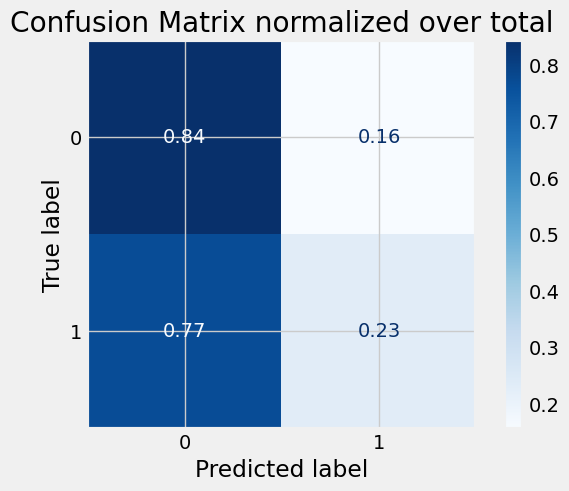

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 

disp = ConfusionMatrixDisplay.from_predictions(
     y_test,
     y_hat, 
     cmap=plt.cm.Blues,
     normalize='true', # Normalized over the true outcomes (rows)  
                       # Shows Type II error rates 
    )
disp.ax_.set_title('Confusion Matrix normalized over total');



Apparently, there are **not so many true positives**.  

### What does the decision tree look like?  

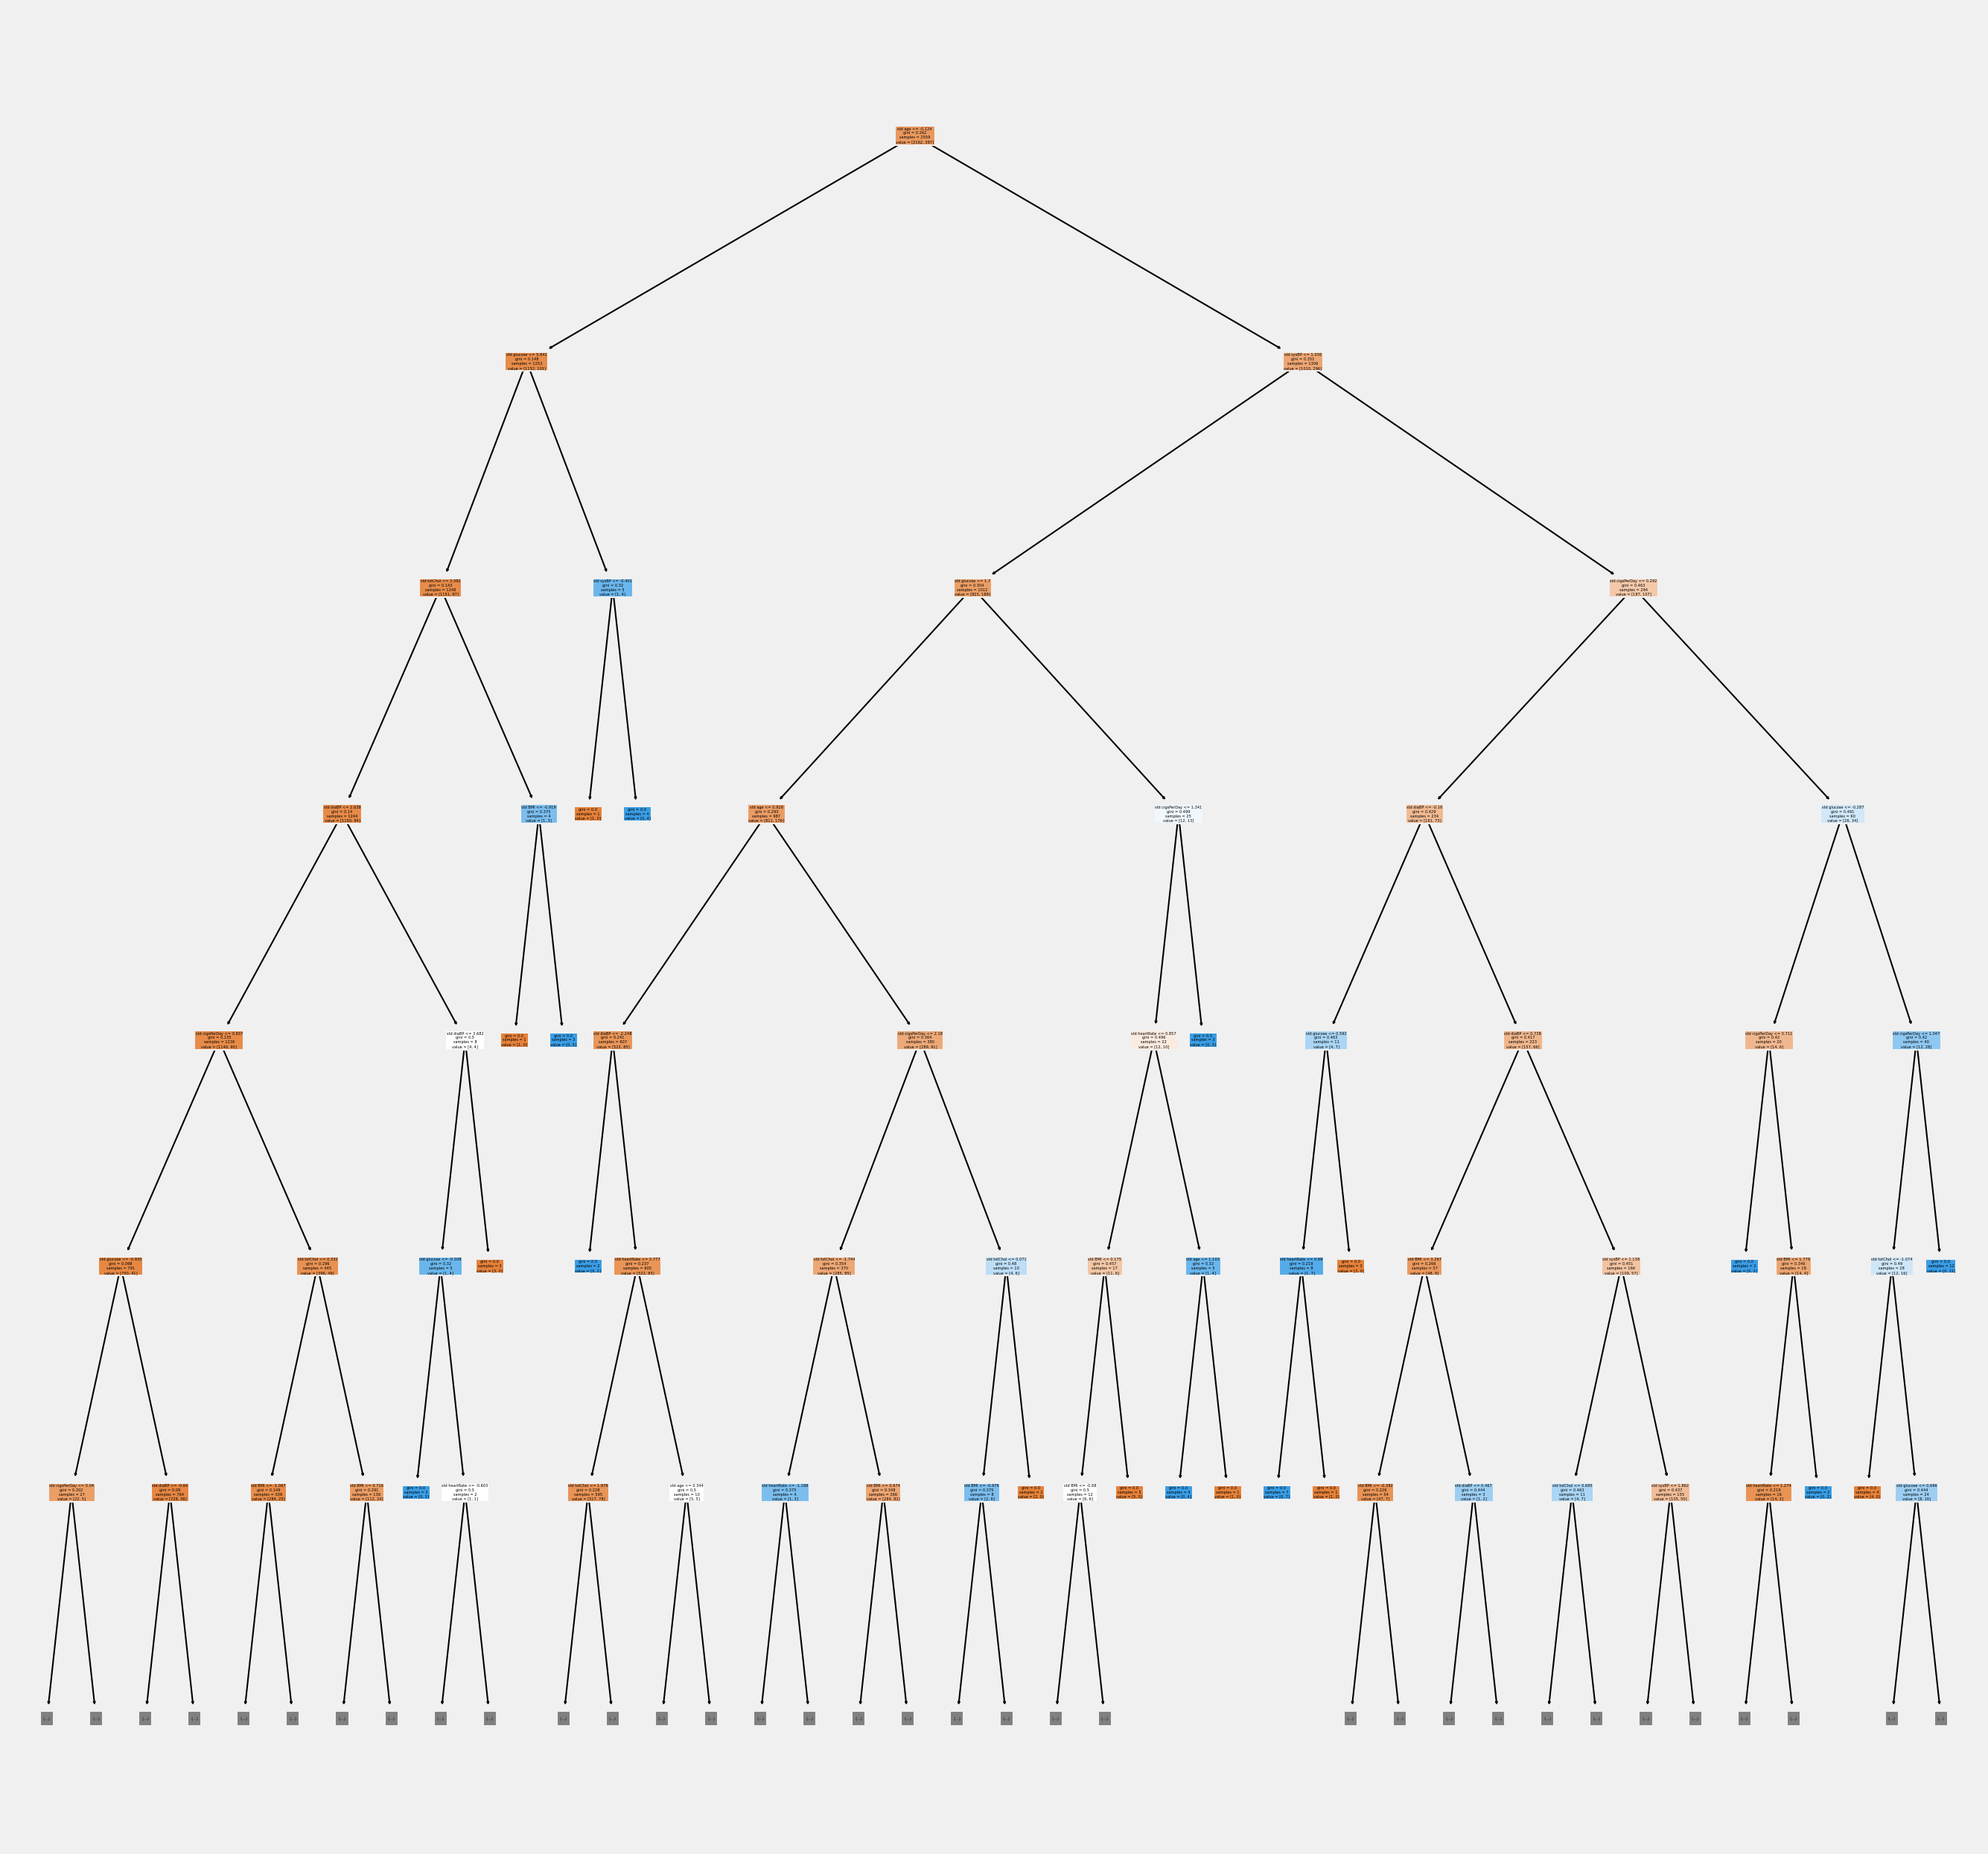

In [39]:
import matplotlib.pyplot as plt
from sklearn import tree

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=300)
tree.plot_tree(model,
               feature_names = predictors, 
               filled = True,
               max_depth=6);



<br> 
<br> 
<br> 
<br> 
<br> 
<br> 

### The classes in the FHD dataset are highly imbalanced 

(There are ways to **try to** deal with that but htey are out of scope). 

#### Why? 

* Maybe not all the predictors are relevant? 
* Maybe the decisions where chosen poorly? 
* Maybe the dataset is not well-suited for desicion trees?



### How is the decision tree generated? 

For instance, is there one 'decision level' per predictor? 

In [40]:
print('# predictors = %d'%len(predictors))
print('Depth of decision tree = %d'%(model.tree_.max_depth))

# predictors = 8
Depth of decision tree = 22


Apparently, a predictor can be used more than once... 

#### There are several deterministic algorithms for generating a single decision tree

They have names such as ID3, C4.5, or CART. 

They vary in some details (binary tree or not, gini or entropy, ...) but share a common logic. 

### Decision tree algorithm requires an Attribute Selection Measure

|   |   |
|:--|:--|
| <img src="https://github.com/david-biron/DATA221imgs/blob/main/icon_definition.png?raw=true" width="50" height=""> | An **Attribute Selection Measure (ASM)** maps the set of features to a set of scores <br> **given a dataset**. The higher the score, the better the feature 'explains' the outcome <br> in a given dataset. For continuous features, the ASM also determines the splitting <br> point, e.g., `age>30`. |



#### The Decision Tree algorithm

Given a choice of an Attribute Selection Measure: 
* Select the best attribute to split the records.
* The selected attribute becomes a **decision node**. 
* Breaks the dataset into smaller subsets depending on the value of the decision attribute. 
* Repeat this proces (recursively) for each child of the decision node <br/> 
**until** one of the following conditions is true: 
    * All remaining records lead to the same decision. 
    * The specified (hyperparameter) maximal tree depth was reached. 
    * The specified (hyperparameter) minimum number of samples to spilt was reached, <br/> e.g., a node with less samples will be made a leaf node.
    * No more features/decisions can increase homogeneity. 



### Example: building a small tree using entropy as an ASM 



|   |   |
|:--|:--|
| <img src="https://github.com/david-biron/DATA221imgs/blob/main/icon_definition.png?raw=true" width="50" height=""> | **Entropy** can be thought of as a measure of inhomogeneity. <br/> The larger it is, the more mixed the sample. |

<center>  
$\begin{eqnarray} 
{\cal E} &=&  -\sum_i p_i \log_2 p_i  \\
\text{ where } p_i &=& \text{ probability of class}_i = \frac{\text{No. in class}_i}{\text{Total no. in both classes}} \\ 
\text{For two classes:} \hspace{7mm} {\cal E} &=&  -\left[ p_0 \log_2 p_0  + (1-p_0) \log_2 (1-p_0)\right]
\end{eqnarray}$
</center>




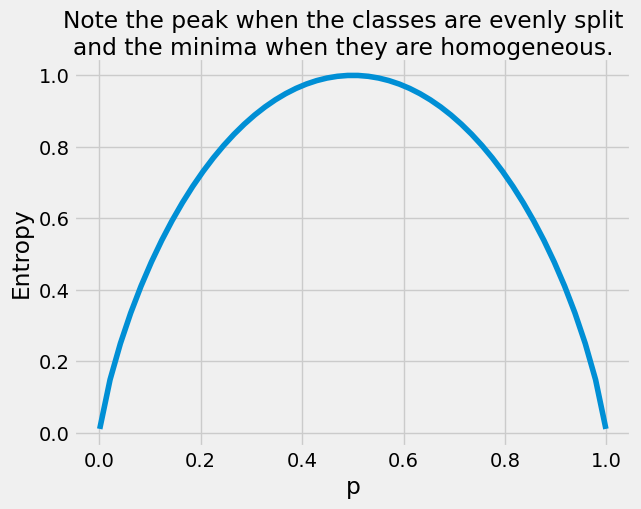

In [41]:
def binary_entropy(p):
    """
    Calculates the entropy of a Bernoulli random variable with 
    probability p.   
    Uses log base 2.
    """
    return -(p * np.log2(p) +(1-p) * np.log2(1-p))

p = np.linspace(0.001,0.999,50)
plt.plot(p, binary_entropy(p))
plt.xlabel('p')
plt.ylabel('Entropy')
supttl = 'Note the peak when the classes are evenly split\n'
supttl += 'and the minima when they are homogeneous.'
plt.suptitle(supttl);


## Consider the following fictitious 'dataset': 

In [42]:
fake_df = pd.DataFrame([[20, 100, 0],
                        [30, 130, 0],
                        [40, 150, 1],
                        [45, 140, 1],
                        [50, 110, 0],
                        [60, 140, 1],
                        [65, 120, 0],
                        [70, 110, 0],
                        [80, 130, 1],
                        [90, 120, 1]], columns=['Age', 'sysBP', 'HD'])
fake_df

,Age,sysBP,HD
0,20,100,0
1,30,130,0
2,40,150,1
3,45,140,1
4,50,110,0
5,60,140,1
6,65,120,0
7,70,110,0
8,80,130,1
9,90,120,1


Proportion of positive cases in the data:

$$\large P(\textrm{HD} = 1) = \tfrac{5}{10} = \tfrac{1}{2}$$

The entropy of the HD label in the overall data set is:

$$\large{\cal E} = -\left[ \tfrac 12 \log_2 \tfrac 12 + \tfrac 12 \log_2 \tfrac 12 \right] = 1.0 $$

Confirm the above calculation with code:

In [43]:
n_1 = (fake_df['HD']==1).sum()
n_0 = (fake_df['HD']==0).sum()
p = n_1 / (n_1 + n_0)
e = binary_entropy(p)

print(f'Number of positive cases (HD=1): n1 = {n_1}')
print(f'Number of negative cases (HD=0): n0 = {n_0}')
print(f'Proportion of positive cases: p = {p}')
print(f'Entropy of HD: E = {e} bits')

Number of positive cases (HD=1): n1 = 5
Number of negative cases (HD=0): n0 = 5
Proportion of positive cases: p = 0.5
Entropy of HD: E = 1.0 bits


### Considering a split

What if we split by `Age < 55`?

Proportions and entropies on either side of the split:

$$
\begin{align}
P(\textrm{HD} = 1 \mid \text{Age} < 55) &= \tfrac{2}{5} &
P(\textrm{HD} = 1 \mid \text{Age} \geq 55) &= \tfrac{3}{5} \\
% 
{\cal E}_{\text{Age} < 55} = -\left[ \tfrac 25 \log_2 \tfrac 25 + \tfrac 35 \log_2 \tfrac 35 \right] &\approx 0.97 & 
{\cal E}_{\text{Age} \geq 55} = -\left[ \tfrac 35 \log_2 \tfrac 35 + \tfrac 25 \log_2 \tfrac 25 \right] &\approx 0.97
\end{align}$$

Half the data points are on each side of the split $P(\text{Age} < 55) = \tfrac{5}{10} = \tfrac{1}{2}$, so the **average entropy** at level 1 would be:

$${\cal E}_{1} = \tfrac{1}{2}{\cal E}_{\text{Age} < 55} + \tfrac{1}{2} {\cal E}_{\text{Age} \geq 55} \approx 0.97$$

Confirm with code:

In [44]:
df_split_older = fake_df[fake_df['Age'] >= 55] # older than 55 
df_split_younger = fake_df[fake_df['Age'] < 55] # younger than 55 

p_older = df_split_older['HD'].mean() # Pr{HD | older}
p_younger = df_split_younger['HD'].mean() # Pr{HD | younger}

e_older = binary_entropy(p_older) # binary entropy of older group 
e_younger = binary_entropy(p_younger) # binary entropy of younger group
 
print(f'Entropy of HD among older: {e_older:.2f} bits')
print(f'Entropy of HD among younger: {e_younger:.2f} bits')

prop_older = (fake_df['Age'] >= 55).mean() # Pr{older}
prop_younger = 1-prop_older # Pr{younger}
e_split = prop_older * e_older + prop_younger * e_younger

print(f'Average entropy of HD at this level: {e_split:.2f} bits')

Entropy of HD among older: 0.97 bits
Entropy of HD among younger: 0.97 bits
Average entropy of HD at this level: 0.97 bits


### Considering a different split

What if we instead split by `sysBP < 125`?

Using more general notation for splits:

Proportions and entropies on either side of the split:

$$
\begin{align}
P(\textrm{HD} = 1 \mid \textrm{yes}) &= \tfrac{1}{5} &
P(\textrm{HD} = 1 \mid  \textrm{no}) &= \tfrac{4}{5} \\
% 
{\cal E}_{yes} = -\left[ \tfrac 15 \log_2 \tfrac 15 + \tfrac 45 \log_2 \tfrac 45 \right] &\approx 0.722 & 
{\cal E}_{no} = -\left[ \tfrac 45 \log_2 \tfrac 45 + \tfrac 15 \log_2 \tfrac 15 \right] &\approx 0.722
\end{align}$$

Half the data points are again on each side of the split $P(yes) = \tfrac{5}{10} = \tfrac{1}{2}$, so the **average entropy** at level 1 would be:

$${\cal E}_{1} = \tfrac{1}{2}{\cal E}_{yes} + \tfrac{1}{2} {\cal E}_{no} \approx 0.722$$

Confirm with code:

In [45]:
# more general notation:

condition = fake_df['sysBP'] < 125

df_split_1_yes = fake_df[condition] # 'yes': condition satisfied
df_split_1_no = fake_df[~condition] # 'no': condition not satisfied

p_1_yes = df_split_1_yes['HD'].mean() # Pr{HD | yes}
p_1_no = df_split_1_no['HD'].mean()   # Pr{HD | no}

e_yes = binary_entropy(p_1_yes) # binary entropy given 'yes'
e_no = binary_entropy(p_1_no)   # binary entropy given 'no'

print(f'Entropy of HD for yes: {e_yes:.3f} bits')
print(f'Entropy of HD for no: {e_no:.3f} bits')

prop_yes = (condition).mean() # Pr{'yes'} = Pr{condition satisfied}
prop_younger = 1-prop_older # Pr{'no'} = Pr{condition not satisfied}
e_split = prop_yes * e_yes + (1-prop_yes) * e_no

print(f'Average entropy of HD at this level: {e_split:.3f} bits')


Entropy of HD for yes: 0.722 bits
Entropy of HD for no: 0.722 bits
Average entropy of HD at this level: 0.722 bits


### Choosing between possible splits

Both splits reduce entropy but the second split is **preferable** because it results in **lower average entropy** than the first. 


### Information gain (in brief) 

$$\boxed{ \ \text{Information Gain} = \text{Entropy}_{\text{parent node}} - \text{Average Entropy}_{\text{child nodes}} \ } $$ 

This is what we want to **maximize**.

### Choosing the best possible split (i.e., learning) 

Coming up with the ${\bf \text{split point}}$ is similar: 

For each feature: 
* The values are sorted
* Mid-points between adjacent values evaluated.
* Best split (best feature/value combination) is chosen. 

<br>
<br>
<br>
<br>

## Another possible criterion: Gini

|   |   |
|:--|:--|
| <img src="https://github.com/david-biron/DATA221imgs/blob/main/icon_definition.png?raw=true" width="50" height=""> | The **Gini** index can be thought of as a measure of inhomogeneity. <br/> The larger it is, the more mixed the sample. |

<center>
$\begin{eqnarray} 
&& {\cal E} =  1 -\sum_{i} p_i^2  \\
\text{ where }  && p_i = \text{ probability of class}_i = \frac{\text{No. in class}_i}{\text{Total no. in both classes}} \\ 
&& \\
\text{For two classes:} && {\cal E} =  1 -\left[ p_0^2  + (1-p_0)^2 \right]
\end{eqnarray}$
</center>



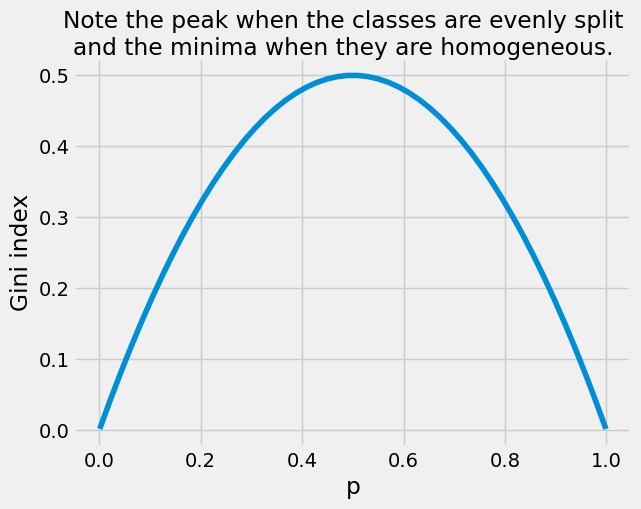

In [46]:
p = np.linspace(0.001,0.999,50)
gini = 1 - (p**2 + (1-p)**2)
plt.plot(p, gini)
plt.xlabel('p')
plt.ylabel('Gini index')
supttl = 'Note the peak when the classes are evenly split\n'
supttl += 'and the minima when they are homogeneous.'
plt.suptitle(supttl);



## Example: Brexit data

This dataset breaks the Brexit vote to $650$ constituencies and looks at demographic statistics such as eduction,  immigration, race/ethnicity, and income. 

Questions the data may address is whether factors such as overall wealth, a multi cultural environment, age, etc. may have influenced the vote. <br/> Or rather, were they good predictors of the vote?  

The data breakdown is based on publically available UK government (census-like) data, UK electoral commission data, and the work of a BBC team that matched the different datasets. 



#### The datasets are fairly clean but there is some wrangling necesary
* A few special characters need to be replaced.
* A few naming discrepencies need to be resolved. 

In [50]:
import pandas as pd
import numpy as np

##############################
# Rudimentary Data Wrangling #
#    (crude, but will do)    #
##############################

# Read ethnicity data file 
ethn_df = pd.read_csv('data/Brexit-Constituency-Ethnicity.csv')

# Rename the constituency column (for later join) 
ethn_df.rename({'ConstituencyName': 'Constituency'}, axis=1, 
               inplace=True)

# Sort alphabetically by constituency
ethn_df.sort_values(by='Constituency', axis=0, ascending=True, 
                    inplace=True, ignore_index=True)

# Correct wrong character
ethn_df.loc[647, 'Constituency'] = 'Ynys Mon' 

# Correct name (extra 'South' moved)
ethn_df.loc[117, 'Constituency'] = \
    'Carmarthen West and South Pembrokeshire' 

# Read constituency data file 
data_df = pd.read_csv('data/Brexit-UK-constituency-data.csv')

# Rename the constituency column (for later join)
data_df.rename({'PCON14NM': 'Constituency'}, axis=1, inplace=True)

# Remove 'England', 'Northern Ireland', 'Scotland', 'UK', 'Wales'
# from constituencies
data_df = data_df[~data_df['Constituency'].isin(\
        ['England', 'Northern Ireland', 'Scotland', 'UK', 'Wales'])]

# Sort alphabetically by constituency
data_df.sort_values(by='Constituency', axis=0, ascending=True, 
                    inplace=True, ignore_index=True)

# Correct wrong character
data_df.loc[647, 'Constituency'] = 'Ynys Mon' 

# Read results (votes) data file 
rslt_df = pd.read_csv('data/Brexit-results.csv')

# Sort alphabetically by constituency
rslt_df.sort_values(by='Constituency', axis=0, ascending=True, 
                    inplace=True, ignore_index=True)

# Make sure that constituencies in ethn_df match those in rslt_df
# and that constituencies in data_df match those in rslt_df
for k in range(len(rslt_df)): 
    if (rslt_df.Constituency[k] in ethn_df.Constituency[k]) or \
       (ethn_df.Constituency[k] in rslt_df.Constituency[k]): 
        ethn_df.loc[k, 'Constituency'] = rslt_df.Constituency.values[k]
    if (rslt_df.Constituency[k] in data_df.Constituency[k]) or \
       (data_df.Constituency[k] in rslt_df.Constituency[k]): 
        data_df.loc[k, 'Constituency'] = rslt_df.Constituency.values[k]

#for c in set(data_df.Constituency) - set(rslt_df.Constituency): 
#    idxs = [i for i in rslt_df.Constituency.index if \
#            c in rslt_df.Constituency[i]]
#    jdxs = [j for j in data_df.Constituency.index if \
#            c in data_df.Constituency[j]]
#    if len(idxs)==1 and len(jdxs)==1:
#        data_df.loc[jdxs[0], 'Constituency'] = \
#                   rslt_df.Constituency.values[idxs[0]]

# Check that data_df, rslt_df, and ethn_df have the same lengths
print('Length of dataframes: ', len(rslt_df), 
                                len(data_df), len(ethn_df))

# Check the class balance between constituencies 'for' and 'against' 
print('Class Balance: %.1f%% for leaving and %.1f%% against.'%\
                      (100*sum(rslt_df.Leave>'50')/len(rslt_df), 
                       100*sum(rslt_df.Leave<'50')/len(rslt_df)))

# Check that data_df, rslt_df, and ethn_df have the same constituencies
print('Constituency name discrepencies:', 
      set(rslt_df.Constituency) - set(data_df.Constituency), 
      set(data_df.Constituency) - set(rslt_df.Constituency), 
      set(rslt_df.Constituency) - set(ethn_df.Constituency),  
      set(ethn_df.Constituency) - set(rslt_df.Constituency) )


Length of dataframes:  650 650 650
Class Balance: 62.9% for leaving and 37.1% against.
Constituency name discrepencies: set() set() set() set()


#### Choosing predictors and dealing with missing values

Here, as opposed to previous datasets, it may make more sense to impute missing demographic statistics than simply drop records with missing values. 

* The number of records is not very large to begin with. 
* The number of missing values is rather small. 
* Statistics such as mean age, income, and education level don't fluctuate wildly for large groups of people (like constituencies). 

In [53]:
###########################################
# Determine predictor and outcome columns #
#    (and fill in some missing values)    #
###########################################

# Creat a 'Brexit' column: 
#    1 for leaving the EU ('yes' to Brexit)
#    0 for staying in the EU ('no' to Brexit)
rslt_df['Brexit'] = (rslt_df.Leave>'50').astype(int)  
                                                     
rslt_df.head(20) 
df = rslt_df
df = df.merge(data_df, how='inner')
df = df.merge(ethn_df, how='inner')

outcome = 'Brexit'
predictors = [
       'salary', 'publicsector', 'degree', 'age', 'nonukborn', 
       'health', 'PopTotalConstNum', 'PopWhiteConst%', 
       'PopMixedConst%', 'PopAsianConst%', 'PopBlackConst%', 
       'PopWhiteReg%',   'PopMixedReg%',   'PopAsianReg%',   
       'PopBlackReg%'
    ] 

# Convert 'x' (code for missing values) to np.nan
print("Missing values in public sector column (no. of 'x's):", 
                                    len(df[df.publicsector=='x']))
df.loc[df.publicsector=='x','publicsector'] = np.nan

# Convert all predictors types to float 
df[predictors] = df[predictors].astype(float)

# Replace missing values with the mean value: 
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
vals2d = df.publicsector.values.reshape(-1, 1)
imp.fit(vals2d) # the imputer fitting function needs a 2d array 
df.publicsector = imp.transform(vals2d).reshape(-1) # pandas need a 
                                                    # 1d array 
print('\nAfter imputing...')    
print("Missing values in public sector column (no. of NaNs):", 
                                            df.isnull().sum().sum())



Missing values in public sector column (no. of 'x's): 18

After imputing...
Missing values in public sector column (no. of NaNs): 0


### Model: 

* Split the data. 
* Calculate mean F1 score by cross-validating the training data. 
* Train/fit the model. 
* Predict using the testing data. 
* Score the model on the predictions and the testing data. 
* Print the number of predictors and the maximal depth of the tree. 


In [55]:
###############################################
# Split data to training and testing datasets #
###############################################
X_train, X_test, y_train, y_test = train_test_split(df[predictors], 
                                                    df[outcome], 
                                                    test_size=0.3) 
                             # different splits -> different trees

#############################################
# Cross validate to get evaluation metircs  #
#############################################

model = dec_tr() 
k_folds = RepeatedKFold(n_splits=20, n_repeats=5, random_state=1)
scores = cross_val_score(model, X_train, y_train, 
                     scoring='f1',
                     cv=k_folds, n_jobs=None) # use one processor 
                               # to succesfully suppress warnings 
print('CV: Mean F1 score=%.2f'%np.abs(scores).mean())


##########################################
# Train the model / fit model parameters #
#       and test on testing dataset      #
##########################################

model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_hat = model.predict(X_test)
print('F1 score for the *training* dataset = %.3f'%\
       f1_score(y_train, y_train_hat))
print('F1 score for the *testing* dataset = %.3f'%\
       f1_score(y_test, y_hat))
print('# predictors = %d'%len(predictors))
print('Depth of the decision tree = %d'%(model.tree_.max_depth))



CV: Mean F1 score=0.88
F1 score for the *training* dataset = 1.000
F1 score for the *testing* dataset = 0.850
# predictors = 15
Depth of the decision tree = 12


#### The training data score is perfect but the testing data score is not worlds apart and the CV score is similar to the testing score. 

Good start! 

#### Still, the model is complicated
* Many predictors ($>10$)
* Deep tree ($>10$)
* Some overfitting (training score is perfect)

<br/> 

<br/> 

<br/> 

<br/> 

<br/> 

<br/> 


## Pruning 

### Pre-pruning

Stopping the growth of the decision tree early by setting hyperparameters. 

In `sklearn`: 
* `max_depth` sets the maximal depth of the tree. 
* `min_samples_leaf` sets minimum number of samples required to be at a leaf node (default=1). 
* `min_samples_split` sets the smallest sample size that can be further split. 

Good values for these hyperparameters can be found with `GridSearchCV` (although there is no guarantee that a better optimum does not exist). 

### Post pruning (Cost Complexity Pruning)

* Typically, the tree is grown freely and afterwards parts of it are removed (to reduce overfitting). 

* In theory, best if every subtree is scored using some classification error metric, e.g., accuracy. <br/> Subtrees that do not improve the performance of the tree on a CV/test dataset are removed. 

However... 

* Systematically evaluating **every subtree** of a complex tree is computationally expensive (it will take forever).  <br/> Cost Complexity Pruning (CCP) is more efficient. 
* Similar to Lasso regularization, CCP places an $L1$ **complexity penalty** on the tree. 
* The strength of the complexity penalty is tuned using the hyperparameter $\alpha$. 
* An good value for $\alpha$ is found through cross-validation. 

|   |   |
|:--|:--|
| <img src="https://github.com/david-biron/DATA221imgs/blob/main/icon_example.png?raw=true" width="50" height=""> | The gist of it is demonstrated in the following example: | 

$\begin{eqnarray}
|T| &=& \text{the number of leafs in the tree}  = \text{'complexity'} \\ 
\{k_\ell\} &=& \text{indices of all the records (predictors/outcome rows) that lead to leaf } \ell \\
y_{k_\ell}, \ \hat y_{k_\ell} &=& \text{actual and predicted outcomes associated with leaf } \ell \\ 
\delta_{\hat y, \ y} &=& \begin{cases} 1 & \text{ if } \hat y = y \\ 0 & \text{ if } \hat y \neq y \end{cases} \\
SE_\ell &=& \sum_{k_\ell}^{} \ \left[ 1 - \delta_{\hat y_{k_\ell}, \ y_{k_\ell}} \right] 
= \text{no. of errors (misclassifications) for leaf } \ell \\ 
\text{Overall score}  &=& \sum_{\ell=1}^{|T|} \ SE_\ell \ \ + \ \alpha |T| \\
&& = \text{total no. of errors summed over all leafs} + \text{complexity penalty} 
\end{eqnarray}$

<img src="https://github.com/david-biron/DATA221imgs/blob/main/ExamplePruningTree2.png?raw=true" width="500"> 

<details><summary><button> $\leftarrow$ Also...</button></summary>
    <br/>
${\bf \text{Reduced error pruning}}$ is done by fusing two leaves together at their parent node if the fusion does not change the prediction outcome. 
</details>


### Cost Complexity Pruning with `sklearn`

* Train your Decision Tree model to its **full depth**
* Compute `ccp_alphas` using `cost_complexity_pruning_path()`
* Compute test/train (or cross-validated) scores for each value in `ccp_alphas`. 
* Plot the scores for each value in `ccp_alphas`.


#### Another way to avoid an overly complicated tree: 

## Feature selection by Importance (I)

Features can be selected using a feature importance score:

|   |   |
|:--|:--|
| <img src="https://github.com/david-biron/DATA221imgs/blob/main/icon_example.png?raw=true" width="50" height=""> | **Feature importance** is a score assigned to each feature based on how significant <br> they are at predicting the outcome. The scores is based on **weighted Gini indices**. | 

* Feature importance scores can provide insight into the data by pointing to the most relevant features (and the least relevant ones). This could inform further data collection, for instance. 

* Feature importance scores can improve the model through feature selection (drop the least important ones). 


### Calculating feature importances


* **The impostance of a Node:** 

$\begin{eqnarray} 
f(\text{ node }) &=& (\% \text{ samples reaching node }) \times (\text{ Gini impurity of node}) \\ 
NodeImportance(\text{ node }) &=& f(\text{node }) - f(\text{ left child }) -  f(\text{ right child }) \\
&& \text{ (for a leaf: } \ \% \text{ samples reaching a child } = 0 \text{)}
\end{eqnarray}$ 


* **The importance of a feature:** 

$\begin{eqnarray}
FeatureeImportance(\text{ feature}_k) &=& \frac{\sum_{\text{nodes splitting on feature}_k} NodeImportance(\text{ node })}{\sum_{\text{all nodes}} NodeImportance(\text{ node })} 
\end{eqnarray}$ 




### The sklearn implementation of decision trees calculates `feature_importances_`

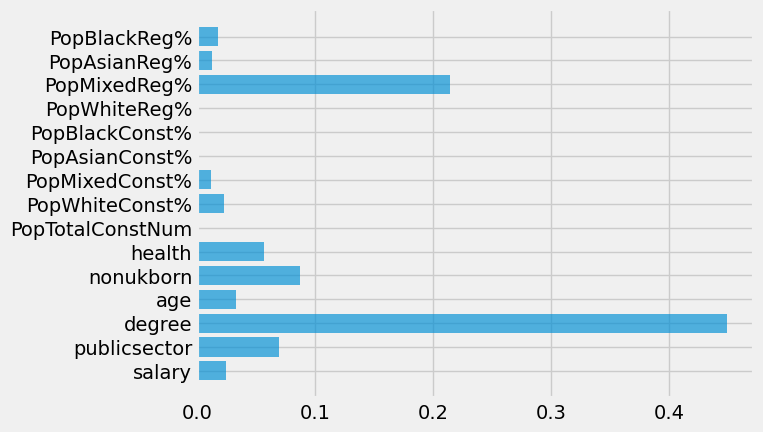

In [56]:
plt.barh(predictors, model.feature_importances_, alpha=0.67);

#### Train an 'extensive tree' and calculate the Cost Complexity Alphas:

In [57]:
###############################################
# Split data to training and testing datasets #
###############################################
X_train, X_test, y_train, y_test = train_test_split(df[predictors], 
                                                    df[outcome], 
                                                    test_size=0.3) 
                                # different splits -> different trees

##############################################
# Initialize an instance of the model object #
##############################################
model = dec_tr() 

##########################################
# Train the model / fit model parameters #
#       and test on testing dataset      #
##########################################

model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_hat = model.predict(X_test)
print('Depth of the decision tree = %d'%(model.tree_.max_depth))
print('The no. of leaves in the decision tree = %d'%\
      (model.get_n_leaves()) )
print('F1 score for the *training* dataset = %.3f'%\
      f1_score(y_train, y_train_hat))
print('F1 score for the *testing* dataset = %.3f'%\
      f1_score(y_test, y_hat))

######################
# Compute ccp_alphas #
######################

path = model.cost_complexity_pruning_path(X_train,y_train)
alphas = path['ccp_alphas']
alphas

Depth of the decision tree = 11
The no. of leaves in the decision tree = 45
F1 score for the *training* dataset = 1.000
F1 score for the *testing* dataset = 0.899


array([0.        , 0.00173718, 0.00212422, 0.00217338, 0.0029304 ,
       0.0032406 , 0.0032967 , 0.0035964 , 0.00376766, 0.00384615,
       0.0040293 , 0.00417436, 0.00417977, 0.0043956 , 0.00494505,
       0.00497964, 0.00544223, 0.00561661, 0.00603792, 0.00633176,
       0.00956891, 0.02812628, 0.08163842, 0.1949952 ])

#### Calculate and plot accuracy scores for each Cost Complexity Alpha:

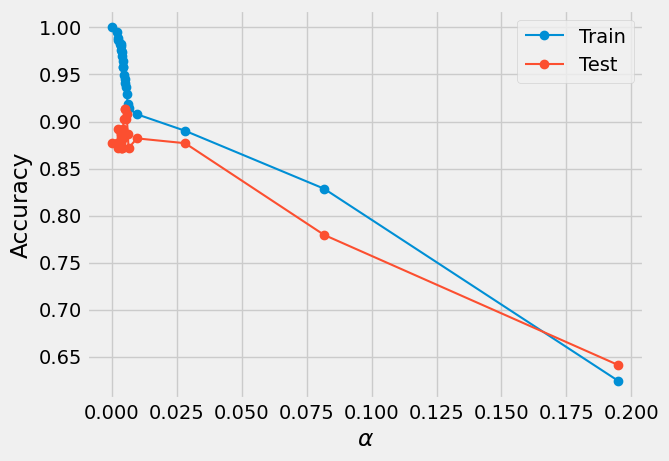

In [58]:
##########################################################
# Compute test/train scores for each value in ccp_alphas #
##########################################################

accuracy_train, accuracy_test = [], []

for alpha in alphas: 
    model_alpha = dec_tr(ccp_alpha=alpha)
    model_alpha.fit(X_train, y_train)
    y_train_hat = model_alpha.predict(X_train)
    y_hat = model_alpha.predict(X_test)
    
    # (BTW, Instead of one test/train score, it more time-consuming  
    #  but more stable to save cross-validation scores, or run this
    # code with several test_train_splits and look at a few 
    #   'best' alphas)
    accuracy_train.append(accuracy_score(y_train, y_train_hat)) 
    accuracy_test.append(accuracy_score(y_test, y_hat))
    
plt.plot(alphas, accuracy_train, color='C0', marker='o', linewidth=1.5)
plt.plot(alphas, accuracy_test, color='C1', marker='o', linewidth=1.5)
plt.xlabel(r'$\alpha$')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test']);


#### Choose an $\alpha$ value that performs well on the testing data and fit the model: 

In [59]:
##########################################
# Train the model / fit model parameters #
#       with the best alpha              #
##########################################

best_alpha = 0.02
model_alpha = dec_tr(ccp_alpha=best_alpha)
model_alpha.fit(X_train, y_train)
y_train_hat = model_alpha.predict(X_train)
y_hat = model_alpha.predict(X_test)

print('Depth of the decision tree = %d'%(model_alpha.tree_.max_depth))
print('The no. of leaves in the decision tree = %d'%\
      (model_alpha.get_n_leaves()) )
print('F1 score for the *training* dataset = %.3f'%\
      f1_score(y_train, y_train_hat))
print('F1 score for the *testing* dataset = %.3f'%\
      f1_score(y_test, y_hat))

 

Depth of the decision tree = 3
The no. of leaves in the decision tree = 4
F1 score for the *training* dataset = 0.928
F1 score for the *testing* dataset = 0.910


In [ ]:
###################
#  Plot the tree  #
#  (a bit later)  #
###################

#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=300)
#tree.plot_tree(model_alpha,
#           feature_names = predictors, 
#           class_names=['no brexit', 'yes brexit'],
#           filled = True);



**Note**: 
* The result is a much simpler model! 
* Overfitting the training data is considerably reduced. 
* Performance on the testing dat didn't suffer... 

### Pruned trees have different importance scores, of course: 

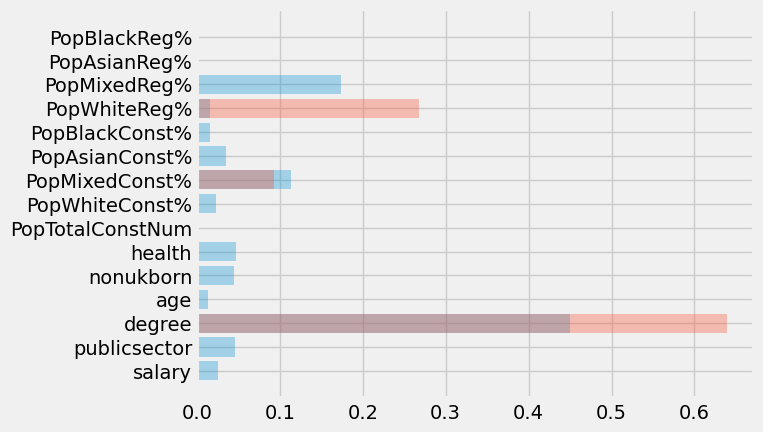

In [60]:
plt.barh(predictors, model.feature_importances_, alpha=0.33)
plt.barh(predictors, model_alpha.feature_importances_, alpha=0.33);



### Visualizing the original and the pruned trees: 

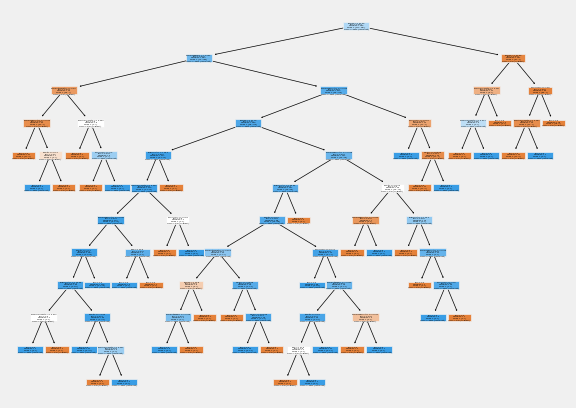

In [61]:
# Original: 
tree.plot_tree(model,
           feature_names = predictors, 
           class_names=['Stay (no Brexit)', 'Leave (yes Brexit)'],
           filled = True);



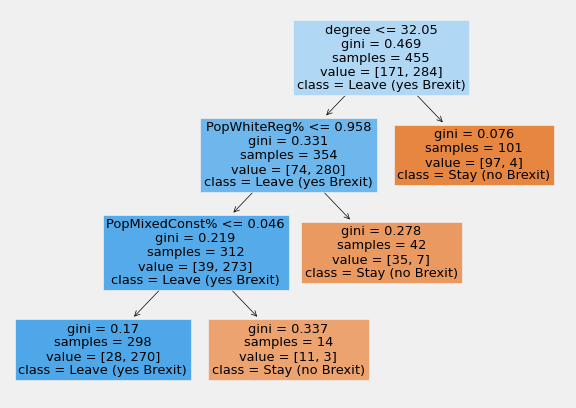

In [62]:
# Pruned:
tree.plot_tree(model_alpha,
           feature_names = predictors, 
           class_names=['Stay (no Brexit)', 'Leave (yes Brexit)'],
           filled = True);



### Finally, it is typically more stable to use cross-validated scores for choosing $\alpha$: 

In [69]:
%%time 

###############################################################
# Compute cross-validated scores for each value in ccp_alphas #
###############################################################

accuracy_CV = []

for alpha in alphas: 
    model_alpha = dec_tr(ccp_alpha=alpha)
    model_alpha.fit(X_train, y_train)
    y_train_hat = model_alpha.predict(X_train)
    y_hat = model_alpha.predict(X_test)
    
    k_folds = RepeatedKFold(n_splits=20, n_repeats=5, random_state=1)
    scores = cross_val_score(model, X_train, y_train, 
                     scoring='accuracy',
                     cv=k_folds, n_jobs=None) 
                  # use one processor to succesfully suppress warnings 
    accuracy_CV.append(scores.mean())    
    



CPU times: user 10.7 s, sys: 100 ms, total: 10.8 s
Wall time: 11.5 s


Depth of the decision tree = 3
The no. of leaves in the decision tree = 4
F1 score for the *training* dataset = 0.928
F1 score for the *testing* dataset = 0.910


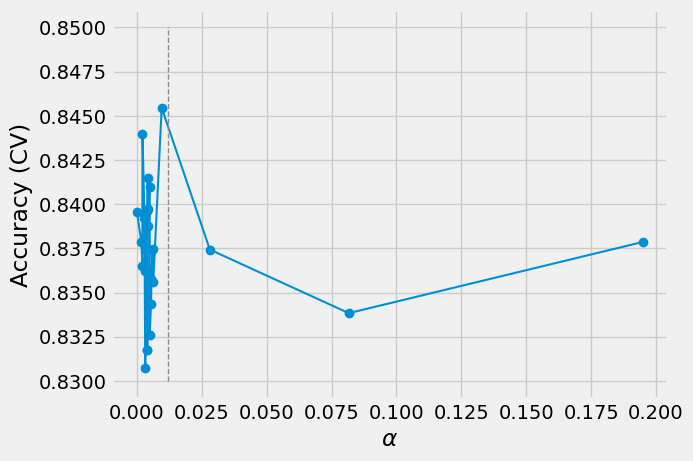

In [72]:
best_alpha = 0.012

plt.plot(alphas, accuracy_CV, color='C0', marker='o', linewidth=1.5)
plt.xlabel(r'$\alpha$')
plt.ylabel('Accuracy (CV)')
plt.plot([best_alpha, best_alpha], [0.83, 0.85], linestyle='dashed', 
         color='C4', linewidth=1);

model_alpha = dec_tr(ccp_alpha=best_alpha)
model_alpha.fit(X_train, y_train)
y_train_hat = model_alpha.predict(X_train)
y_hat = model_alpha.predict(X_test)

print('Depth of the decision tree = %d'%(model_alpha.tree_.max_depth))
print('The no. of leaves in the decision tree = %d'%\
      (model_alpha.get_n_leaves()) )
print('F1 score for the *training* dataset = %.3f'%\
      f1_score(y_train, y_train_hat))
print('F1 score for the *testing* dataset = %.3f'%\
      f1_score(y_test, y_hat))



## Ensemble methods 

Single trees are **sensitive to sample size:** 
* Small datasets are particularly prone to overfitting. 
* Large ones can result in overly complex trees. 

<br> 

Using **multiple (weak) learners** can yield better predictions. 



